In [2]:
!pip3 uninstall statsmodels

Found existing installation: statsmodels 0.12.2
Uninstalling statsmodels-0.12.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.12.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.12.2


In [3]:
!pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.0 MB/s 


In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.3 MB/s 


In [6]:
import pandas as pd
import zipfile
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

## Step 1: Read multiple csv files zipped in one file and concatenate them.

In [7]:
#Read the zip file that contains multiple csv file
from zipfile import ZipFile
from google.colab import files
!wget 'https://raw.githubusercontent.com/Myloveismilk/vn_stock_price/main/data/archive.zip'
url = '/content/archive.zip'
df = pd.concat(
    [pd.read_csv(ZipFile(url).open(i)) for i in ZipFile(url).namelist()],
    ignore_index=True
)

--2022-10-27 14:36:10--  https://raw.githubusercontent.com/Myloveismilk/vn_stock_price/main/data/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3066402 (2.9M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   2.92M  --.-KB/s    in 0.08s   

2022-10-27 14:36:10 (35.9 MB/s) - ‘archive.zip’ saved [3066402/3066402]



In [8]:
#See the first 5 rows of the dataset
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2019-07-30 00:00:00.000000000,9509.07,9535.00,9503.07,9517.75,381.293856,2019-07-30 00:29:59.999000064,3.631211e+06,3492,216.528742,2.062189e+06,0
1,2019-07-30 00:30:00.000000000,9517.03,9539.00,9507.00,9532.58,258.514869,2019-07-30 00:59:59.999000064,2.462134e+06,3133,141.887550,1.351182e+06,0
2,2019-07-30 01:00:00.000000000,9533.59,9534.00,9500.00,9500.25,275.797270,2019-07-30 01:29:59.999000064,2.624322e+06,3583,114.238457,1.087402e+06,0
3,2019-07-30 01:30:00.000000000,9500.25,9514.46,9460.71,9465.25,485.218470,2019-07-30 01:59:59.999000064,4.604004e+06,5330,225.681291,2.141459e+06,0
4,2019-07-30 02:00:00.000000000,9465.25,9488.94,9430.01,9460.42,498.669626,2019-07-30 02:29:59.999000064,4.717269e+06,6197,228.535910,2.162163e+06,0


## Step 2: Drop, rename some columns and format their types.

In [9]:
df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'TB Base Volume',
       'TB Quote Volume', 'Ignore'],
      dtype='object')

In [10]:
#Some columns isn't necessary for predicting the bitcoin price, so let's remove it.
df = df.drop(columns= ['Close Time','Quote Asset Volume', 'Number of Trades', 'TB Base Volume','TB Quote Volume', 'Ignore'])

In [11]:
df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [12]:
#The names of all columns seem to be not in the right format, so let's change them
df = df.rename(columns= {'Open Time':'Date'})

In [13]:
df.tail()

,Date,Open,High,Low,Close,Volume
55377,2022-09-27 16:30:00.000000000,19492.21,19499.25,18918.77,19110.79,26161.20797
55378,2022-09-27 17:00:00.000000000,19110.79,19115.89,18863.70,18951.06,18934.52059
55379,2022-09-27 17:30:00.000000000,18951.06,19036.61,18863.01,18957.20,16295.64670
55380,2022-09-27 18:00:00.000000000,18957.95,18997.46,18816.32,18951.87,15640.01557
55381,2022-09-27 18:30:00.000000000,18950.71,19159.83,18924.64,19103.23,15654.96482


In [14]:
#Let's look at the type of each column
df['Date'] = df['Date'].astype('string')
df.dtypes

Date       string
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [15]:
#We don't need a specific time in our dataset, just need the date
def remove_time(column):
  temp = 0
  for i in range(len(column)):
    column[i] = column[i][0: 10]
    if temp <= 10:
      print(column[i])
      temp += 1

In [16]:
remove_time(df['Date'])

2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30


In [17]:
#Change date type to datetime64
df['Date'] = df['Date'].astype('datetime64')

In [18]:
#Keep only roundly a year's values, drop the redundant.
remove_part = df[df['Date'] <= '2021-09-26']
df = df.drop(remove_part.index, axis = 0)

In [19]:
# We see that there many redundant dates so we need to delele them, just keep the final price of the day.
df = df.drop_duplicates('Date',keep='last')
df.set_index('Date', inplace= True)

In [20]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-27,42680.34,42802.13,42098.00,42147.35,1981.83444
2021-09-28,41548.45,41549.56,40888.00,41026.54,1643.33144
2021-09-29,41409.37,41580.67,41375.63,41524.28,472.27911
2021-09-30,43718.54,43900.00,43704.02,43824.10,477.37185
2021-10-01,48026.54,48171.37,47954.76,48141.61,434.44912


In [21]:
from pmdarima.model_selection import train_test_split

train_data, test_data = train_test_split(df['Close'], test_size = 70)
test_data.shape, train_data.shape

((70,), (296,))

## Step 3: Handle Missings

In [22]:
df.shape

(366, 5)

In [23]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [24]:
#The dataset look fine now, let's save it for future work.
df.to_csv('bitcoin_price.csv')

## Step 4: Quick visualization

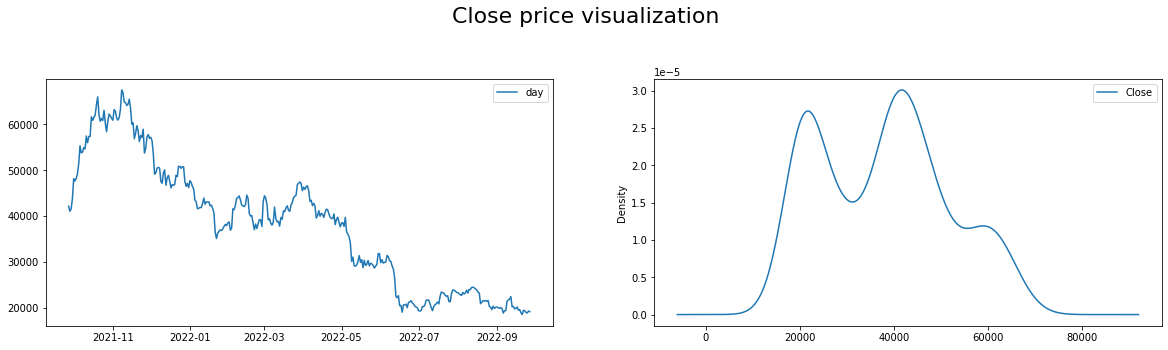

In [25]:
fig = plt.figure(figsize=[20, 10]);
plt.suptitle('Close price visualization', fontsize=22)

plt.subplot(221)
plt.plot(df['Close'], '-', label= 'day');
plt.legend();

plt.subplot(222)
df['Close'].plot(kind = 'kde');
plt.legend();

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period = 3)

<Figure size 432x288 with 0 Axes>

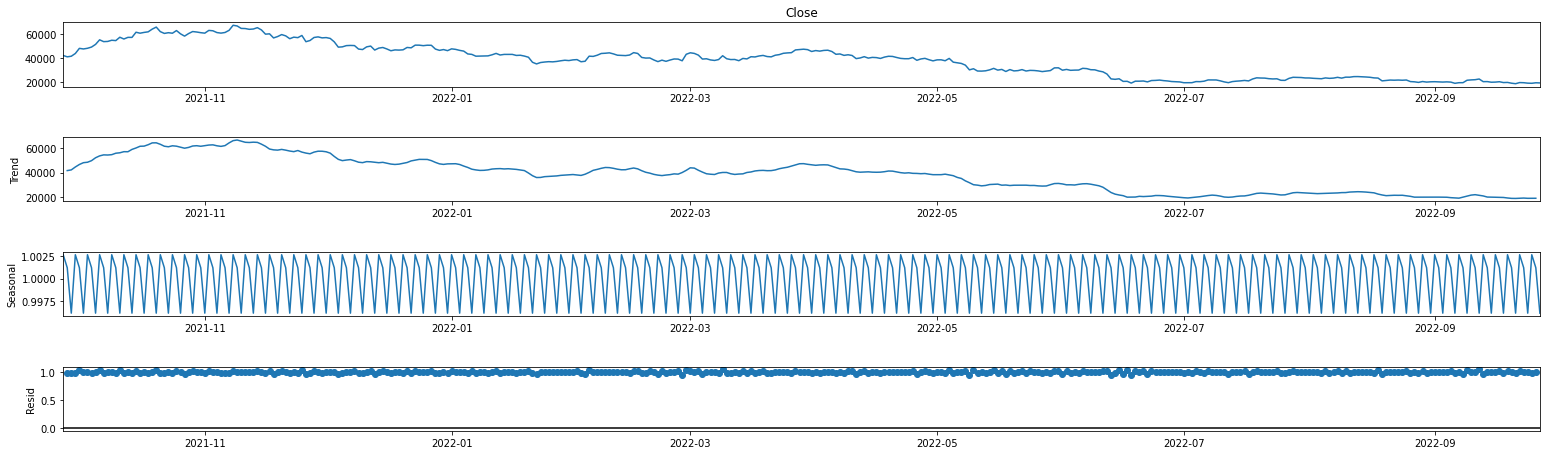

In [27]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(25, 7)

## Step 5: Stationarity test

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
# H0 : It is not stationary
# H1 : It is stationary
def adfuller_test(close_price):
  test_result = adfuller(close_price)
  labels = ['Test Statistic', 'p_value', 'Lag', 'Number of observations']
  for result, label in zip(test_result, labels):
    print(label + ' : ' + str(result))
  for key,value in test_result[4].items():
    print(f"critical value {key} :=  {value}")
  
adfuller_test(df['Close'])

Test Statistic : -0.48683035626274185
p_value : 0.8945609433187011
Lag : 0
Number of observations : 365
critical value 1% :=  -3.4483935212959844
critical value 5% :=  -2.8694912343676497
critical value 10% :=  -2.571005879151811


We can see that the p_value is much greater than 0.05 and also the test statistic is greater than all critical values so the data is non-stationary.

In [30]:
df['seasonal_first_difference'] = df['Close'] - df['Close'].shift(1)
df['seasonal_first_difference'][0:5]

Date
2021-09-27        NaN
2021-09-28   -1120.81
2021-09-29     497.74
2021-09-30    2299.82
2021-10-01    4317.51
Name: seasonal_first_difference, dtype: float64

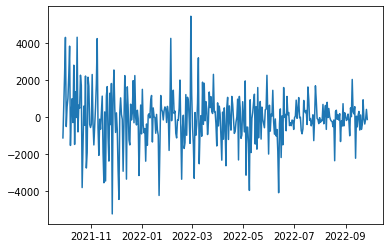

In [31]:
plt.plot(df['seasonal_first_difference'])

In [32]:
# Lets see the adf test result after differencing.
adfuller_test(df['seasonal_first_difference'].dropna())

Test Statistic : -14.297340705864363
p_value : 1.2459479029446355e-26
Lag : 1
Number of observations : 363
critical value 1% :=  -3.448493650810824
critical value 5% :=  -2.8695352280356556
critical value 10% :=  -2.5710293341377715


The p_value is now less than 0.05 so we can reject the NULL hypothesis and the data is now stationary

##Step 6: Identifying the order of AR and MA terms

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


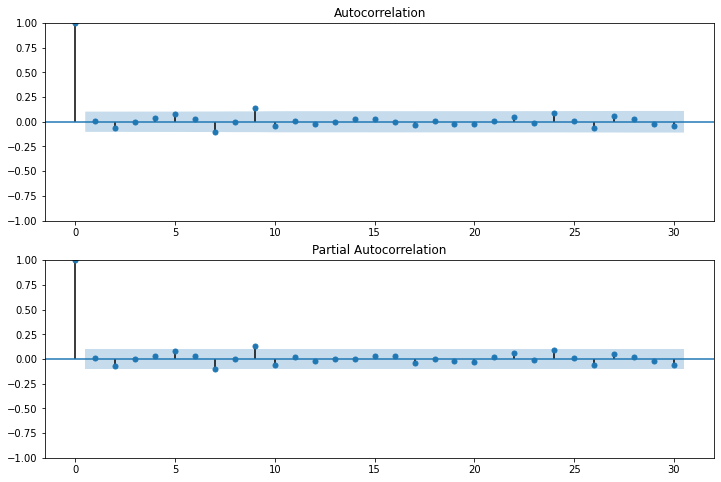

In [33]:
#Plot PACF & ACF chart
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_first_difference'].dropna(),lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_first_difference'].dropna(),lags=30,ax=ax2)

So we can see here the p = 2, d = 2, q = 6, let's move on to build the model.

##Step 7: Modeling

In [34]:
from pmdarima.arima import auto_arima

In [35]:
# arima_model = auto_arima(train_data, start_p=1, start_q=1,
#                            max_p=3, max_q=3, m=12,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True) 
# print(arima_model.summary())
# arima_model.plot_diagnostics(figsize=(15,8))
# plt.show()

In [36]:
import statsmodels.api as sa

In [37]:
model=sa.tsa.statespace.SARIMAX(train_data,order=(0, 1, 1),seasonal_order=(2,1,0,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  296
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -2536.168
Date:                             Thu, 27 Oct 2022   AIC                           5080.335
Time:                                     14:36:16   BIC                           5094.917
Sample:                                 09-27-2021   HQIC                          5086.182
                                      - 07-19-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0077      0.079     -0.098      0.922      -0.162       0.146
ar.S.L12      -0.4111      0.025    -16.435      0.000      -0.460      -0.362
ar.S.L24      -0.2665      0.025    -10.680      0.000      -0.315      -0.218
sigma2      4.468e+06   1.32e-09   3.39e+15      0.000    4.47e+06    4.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               112.74
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.2e+30. Standard errors may be unstable.
"""

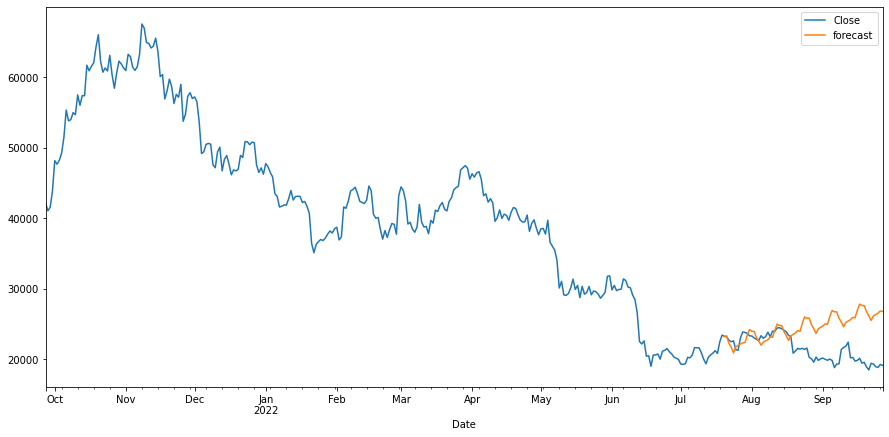

In [39]:
df['forecast'] = results.predict(start = 296, end = 296 + 70, dynamic = True)
df[['Close','forecast']].plot(figsize=(15,7))

We see that in the first phase of the prediction, the orange line fit well to the actual line but the rest of the result of the test set, the prediction line still goes up and therefore it is not accurate.

In [54]:
#Score the prediction
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

y_pred = df['forecast'].dropna().reset_index(drop= True)
mse = mean_squared_error(test_data, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 19430827.453384463
MAE: 3405.0659528785172
RMSE: 4408.041226370786
MAPE: nan


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4024: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)
